# Estimating the Cumulative case load of RSV for children in Denmark

In [2]:
source("common.R")

s = 1.2
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

age_groups <- c("0-5 months", "6-11 months",  "1 year olds", "2 year olds", "3-5 years")

df <- read_data()%>%
  filter(`Age Group` %in% age_groups) 

last_date <- max((df%>%filter(value!=0))$Date)

caption = paste("Plot by @bjornpiltz | Source: Statens Serum Institut,", last_date)

df %>%
  tail

Year,Week,Age Group,Season,type,value,Date
<dbl>,<int>,<fct>,<chr>,<chr>,<dbl>,<date>
2025,52,3-5 years,2021/22,tested,0,2025-12-28
2025,52,3-5 years,2022/23,admissions,0,2025-12-28
2025,52,3-5 years,2022/23,cases,0,2025-12-28
2025,52,3-5 years,2022/23,deaths,0,2025-12-28
2025,52,3-5 years,2022/23,incidens,0,2025-12-28
2025,52,3-5 years,2022/23,tested,0,2025-12-28


#### Methodology
The underlying assumption is that if a child in the ´6-11 months´ age group was admitted/tested in Week 13,2020, it was equally likely to have been born in any of the weeks 14-40, 2019

In [2]:
lags <-
  list(
    list(age_group = "0-5 months",  lag_weeks =   0, duration_weeks = 26),
    list(age_group = "6-11 months", lag_weeks =  26, duration_weeks = 26),
    list(age_group = "1 year olds", lag_weeks =  52, duration_weeks = 52),
    list(age_group = "2 year olds", lag_weeks = 104, duration_weeks = 52),
    list(age_group = "3-5 years",   lag_weeks = 156, duration_weeks = 104)
  )

result <- data.frame()

for (lag in lags){
  age_group <- lag$age_group
  lag_weeks <- lag$lag_weeks
  duration_weeks <- lag$duration_weeks
  print(age_group)

  tmp <-
    df%>%
    filter(`Age Group` == age_group)%>%
    filter(value != 0)%>%
    select(-`Age Group`, -Season, -Year, -Week)%>%
    rename(case_date = Date)

  for (lag_week in lag_weeks:(lag_weeks+duration_weeks-1)){
    result <-
    rbind(result, 
          tmp%>%
            mutate(birth_date = case_date-(lag_week*7),
                   value = value/duration_weeks))
  }
}

result <-
  result%>%
  group_by(type, case_date, birth_date)%>%
  summarise(value = sum(value), .groups = "drop")%>%
  mutate(case_year = as.integer(substr(ISOweek::ISOweek(case_date), 1, 4)),
         case_week = as.integer(substr(ISOweek::ISOweek(case_date), 7, 8)),
         birth_year = as.integer(substr(ISOweek::ISOweek(birth_date), 1, 4)),
         birth_week = as.integer(substr(ISOweek::ISOweek(birth_date), 7, 8)))

result%>%
  head

[1] "0-5 months"
[1] "6-11 months"
[1] "1 year olds"
[1] "2 year olds"
[1] "3-5 years"


type,case_date,birth_date,value,case_year,case_week,birth_year,birth_week
<chr>,<date>,<date>,<dbl>,<int>,<int>,<int>,<int>
admissions,2015-10-04,2013-10-13,0.01923077,2015,40,2013,41
admissions,2015-10-04,2013-10-20,0.01923077,2015,40,2013,42
admissions,2015-10-04,2013-10-27,0.01923077,2015,40,2013,43
admissions,2015-10-04,2013-11-03,0.01923077,2015,40,2013,44
admissions,2015-10-04,2013-11-10,0.01923077,2015,40,2013,45
admissions,2015-10-04,2013-11-17,0.01923077,2015,40,2013,46


In [3]:
birth_year <- seq(2010, 2022)
births <- c(63411, 58998, 57916, 55873, 56870, 58205, 61614, 61397, 61476, 61167, 60937, 63473, 
            63473) #  we repeat the 2021 value for 2022

df_births <-
  data.frame(birth_year, births)


In [4]:
plotCumulative <- function(data, type_){
  data%>%
    filter(type == type_)%>%
    mutate(age_at_admission = (case_year-birth_year)*52 + case_week-birth_week)%>%
    group_by(birth_year, age_at_admission)%>%
    summarise(value = sum(value), .groups = "drop")%>%
    filter(birth_year >= 2016 & birth_year < 2023)%>%
    group_by(birth_year)%>%
    mutate(value = cumsum(value))%>%
    merge(df_births) %>%
    mutate(label = paste("Born", birth_year))%>% 
    ggplot(aes(x = age_at_admission/52, y = value/births*100000, color = as.factor(birth_year))) +
    geom_line() +
    scale_y_continuous(labels = scales::comma) +
    gghighlight(label_key = label)   
}

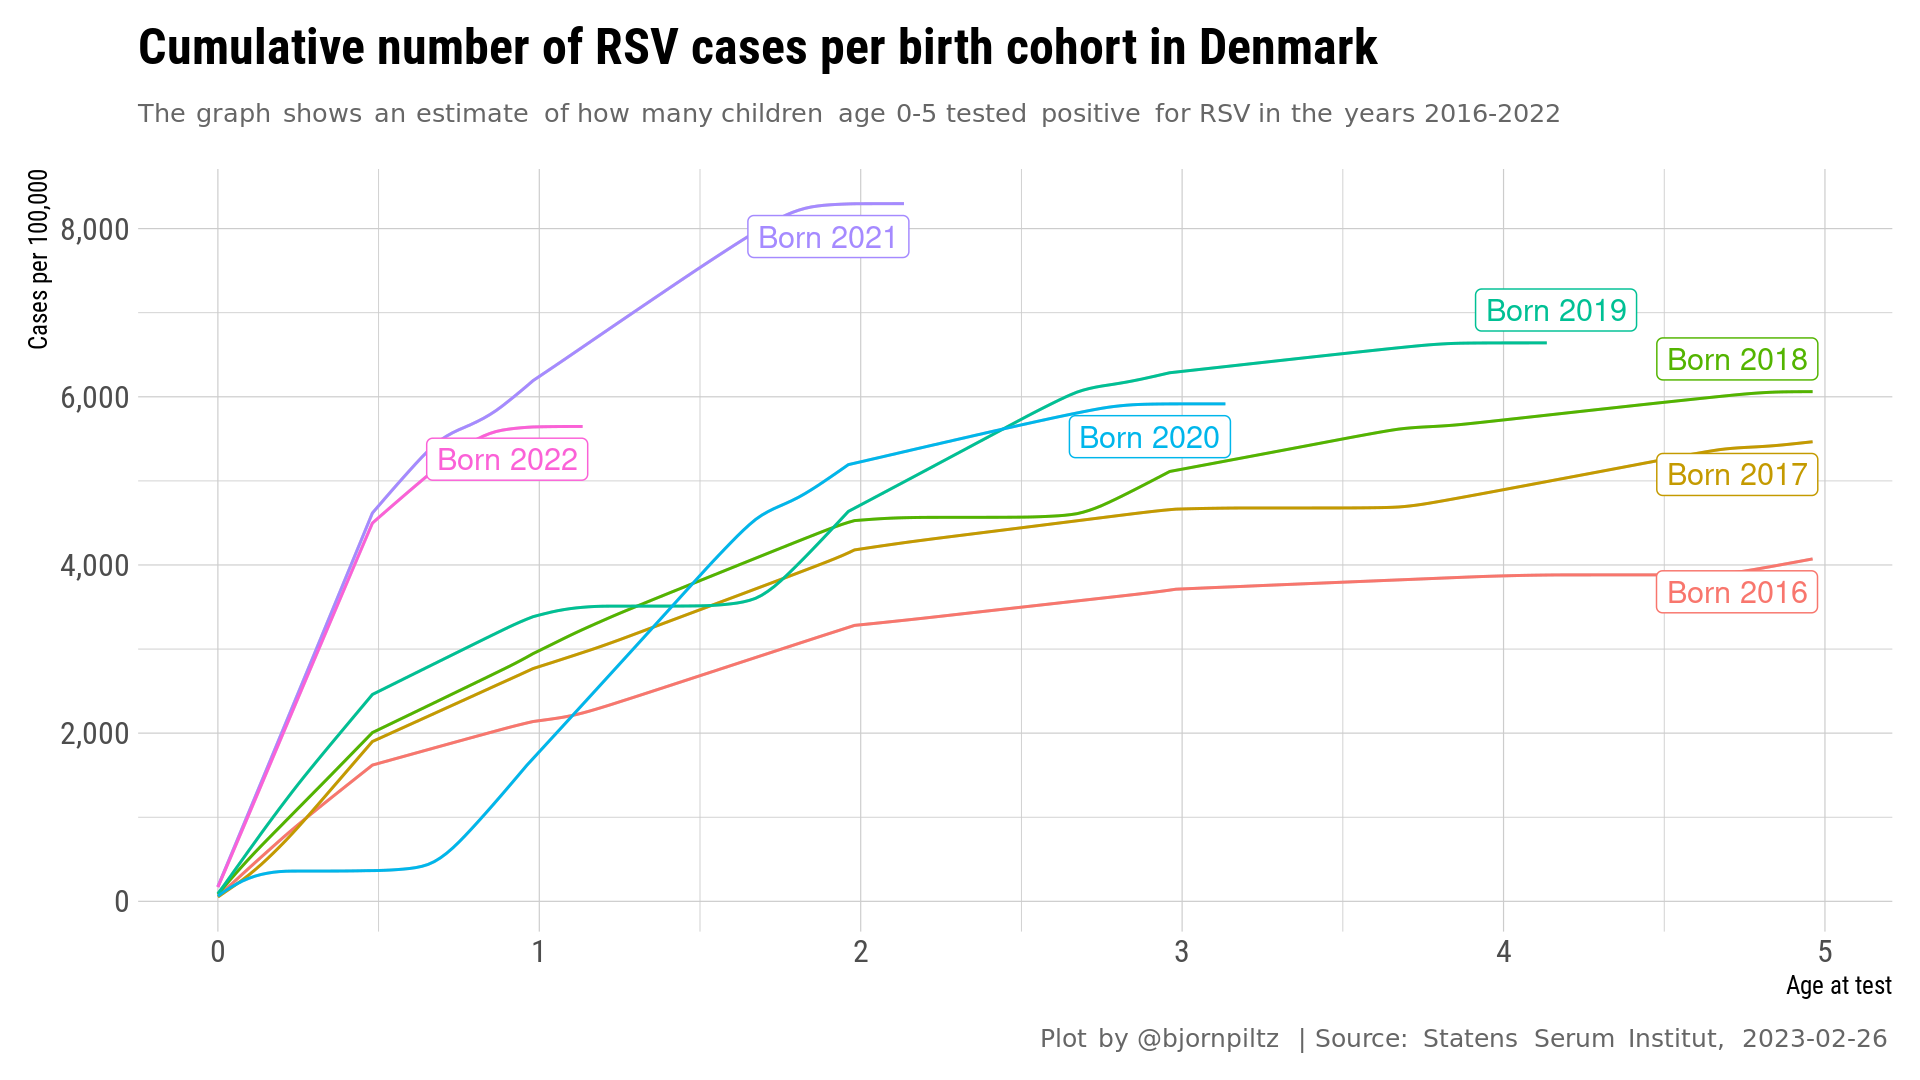

In [11]:
set.seed(42)

plotCumulative(result, "cases") +
  labs(title = "Cumulative number of RSV cases per birth cohort in Denmark",
       subtitle = "The graph shows an estimate of how many children age 0-5 tested positive for RSV in the years 2016-2022",
       caption = caption,
       x = "Age at test", y = "Cases per 100,000") +
  savePlot("cumulative_cases")

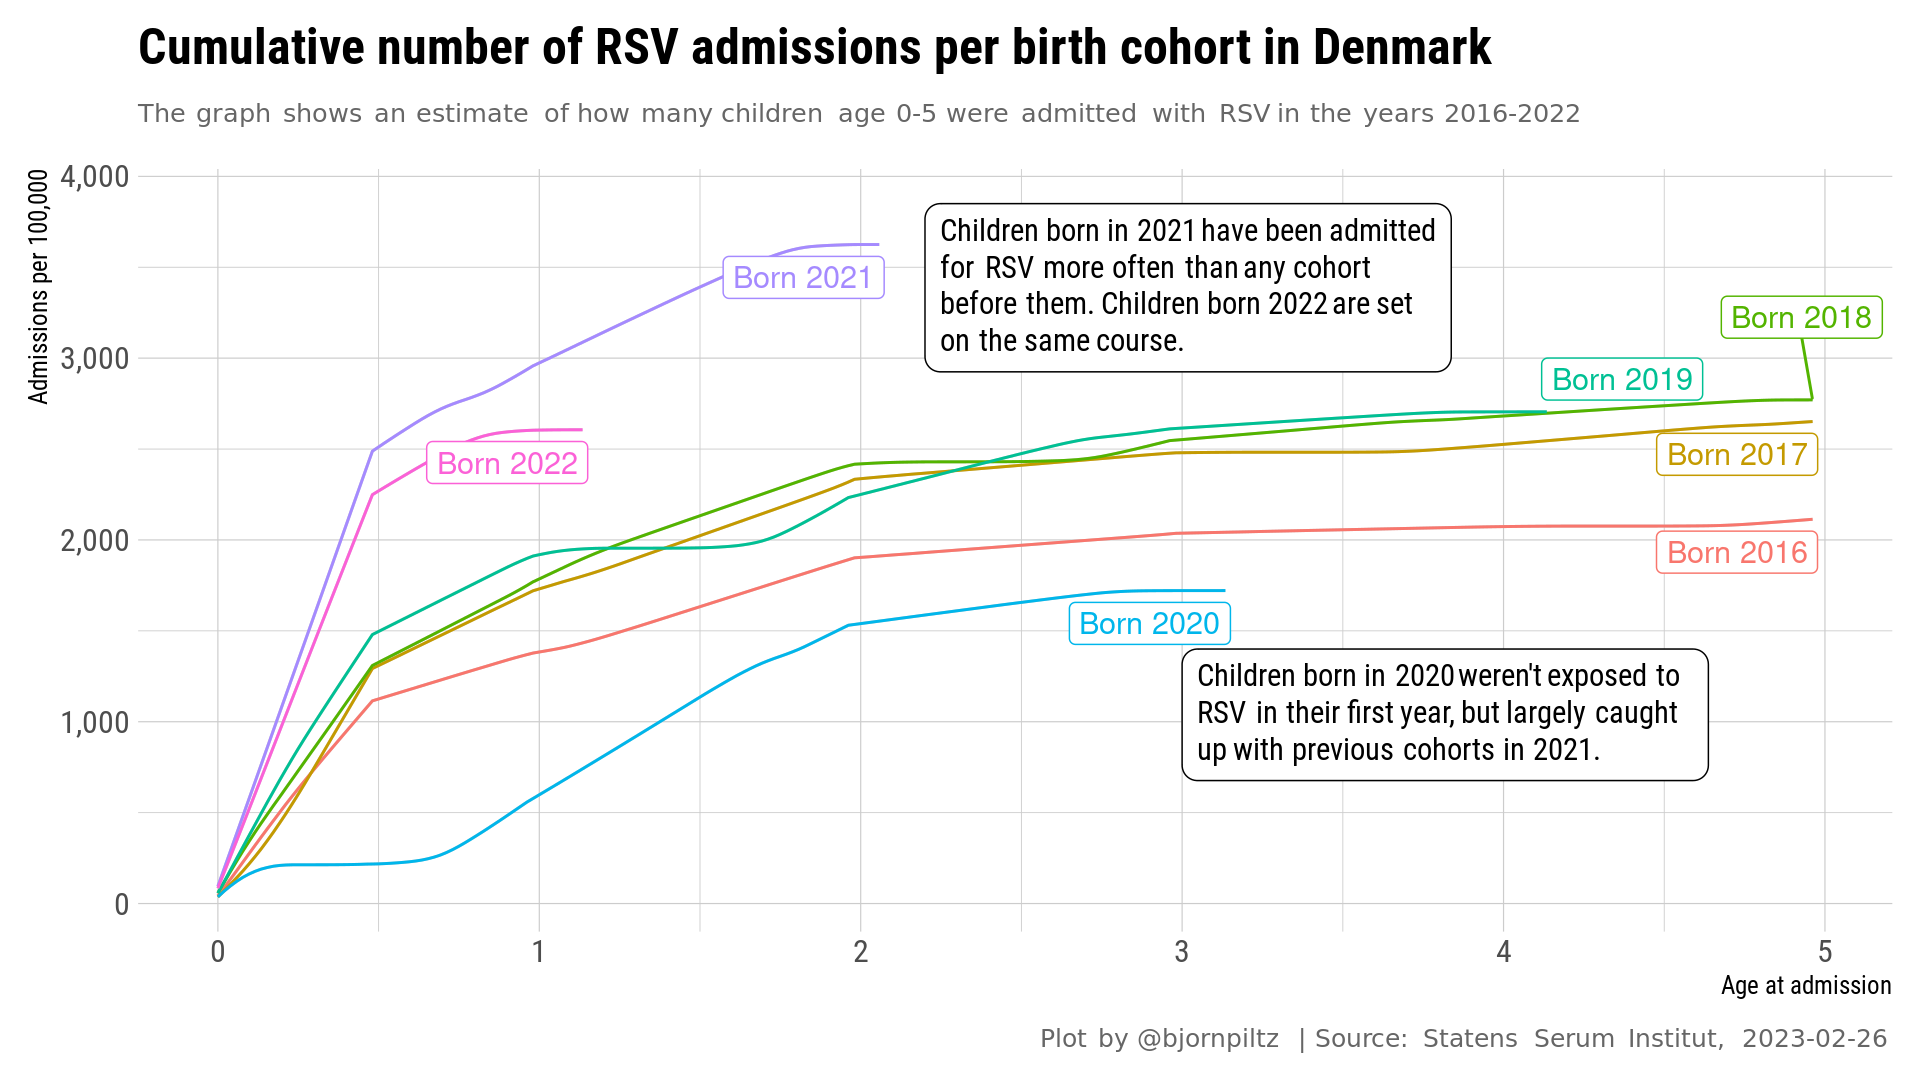

In [12]:
dummy <- data.frame(
  x = c(2.2, 3),
  y = c(3850, 1400),
  label = c("Children born in 2021 have been admitted for RSV more often than any cohort before them. Children born 2022 are set on the same course.",
            "Children born in 2020 weren't exposed to RSV in their first year, but largely caught up with previous cohorts in 2021.")
           )

set.seed(42)

plotCumulative(result, "admissions") +
  labs(title = "Cumulative number of RSV admissions per birth cohort in Denmark",
       subtitle = "The graph shows an estimate of how many children age 0-5 were admitted with RSV in the years 2016-2022",
       caption = caption,
       x = "Age at admission", y = "Admissions per 100,000") +
  geom_textbox(data = dummy, aes(x, y, label = label, color = NULL),
               family = "Roboto Condensed", width = grid::unit(0.3, "npc"), 
               hjust = 0, vjust = 1) +
  savePlot("cumulative_admissions")

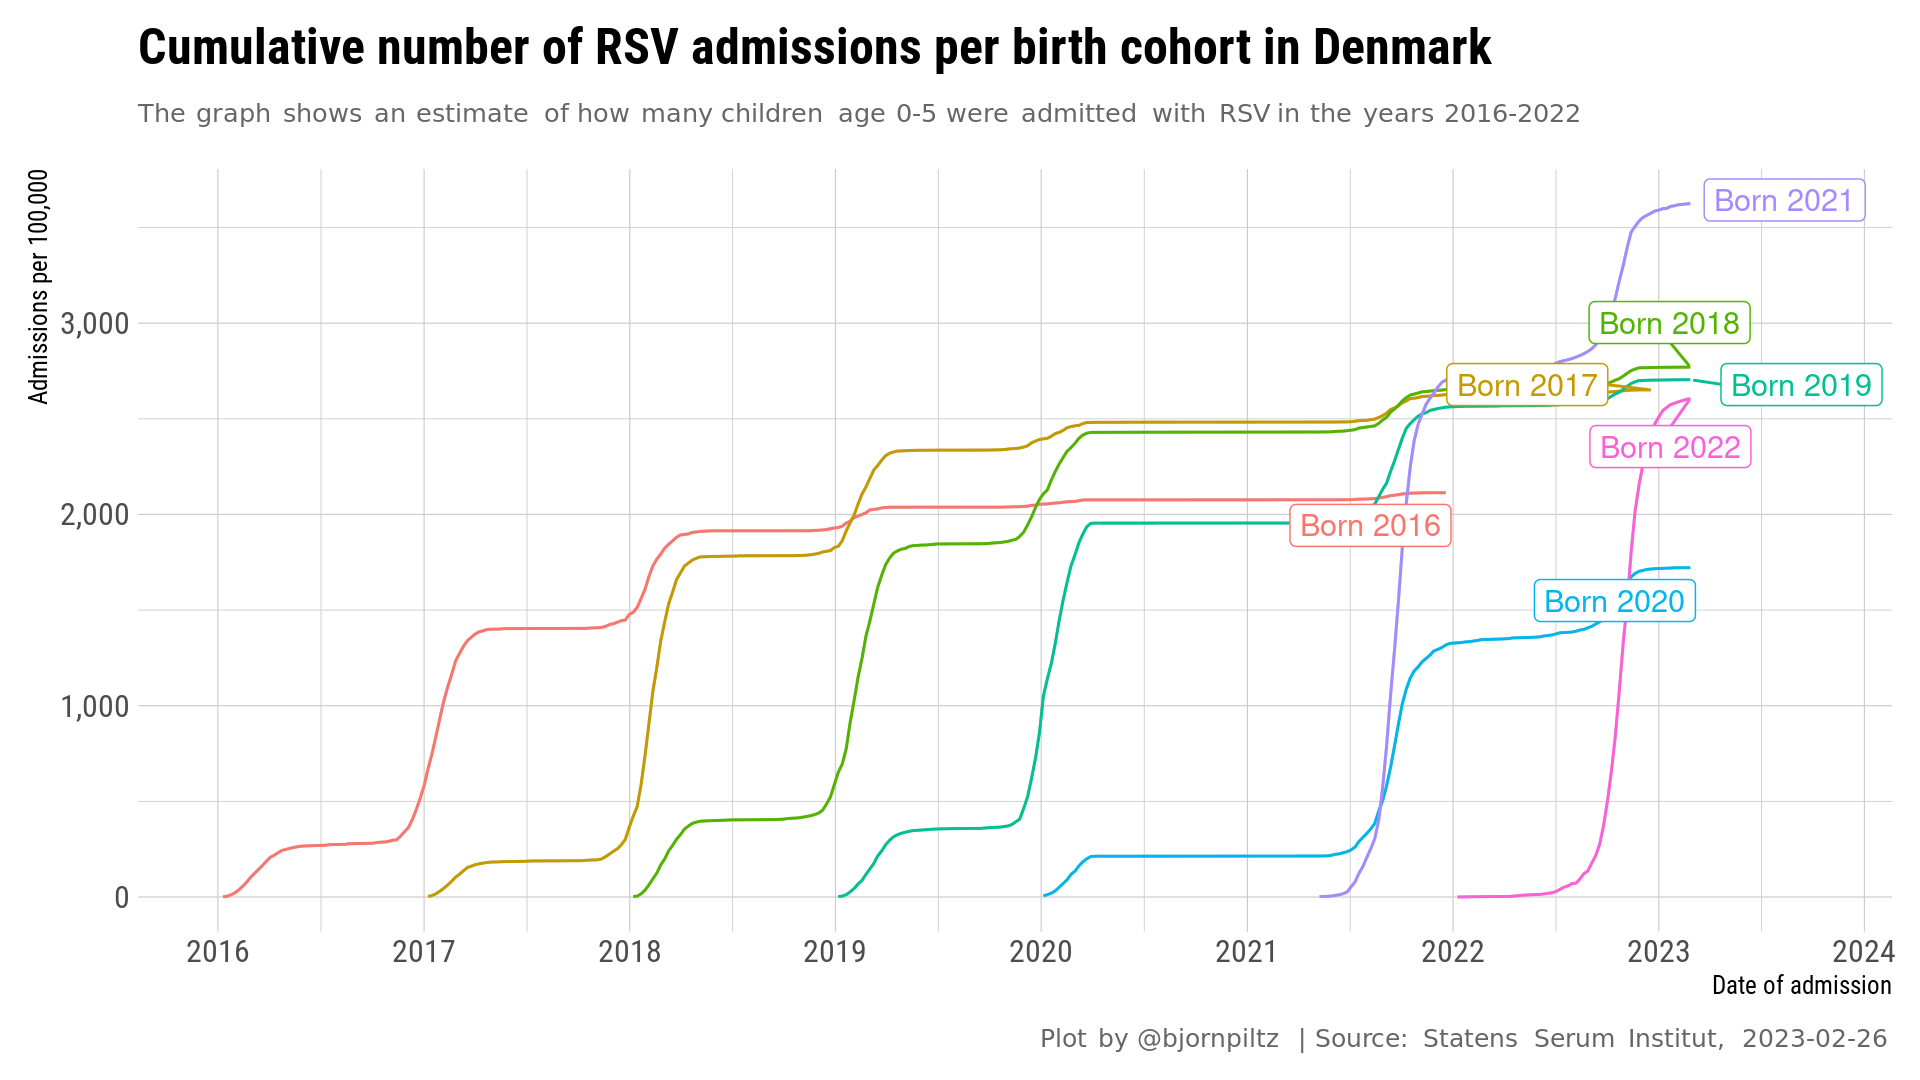

In [10]:
set.seed(2)

result%>%
  filter(type == "admissions")%>%
  group_by(birth_year, case_date)%>%
  summarise(value = sum(value), .groups = "drop")%>%
  filter(birth_year >= 2016 & birth_year < 2023)%>%
  group_by(birth_year)%>%
  mutate(value = cumsum(value))%>%
  merge(df_births) %>%
  mutate(label = paste("Born", birth_year))%>% 
  ggplot(aes(x = case_date, y = value/births*100000, color = as.factor(birth_year))) +
  labs(title = "Cumulative number of RSV admissions per birth cohort in Denmark",
       subtitle = "The graph shows an estimate of how many children age 0-5 were admitted with RSV in the years 2016-2022",
       caption = caption,
       x = "Date of admission", y = "Admissions per 100,000") +
  geom_line()+
  scale_y_continuous(labels = scales::comma) +
  scale_x_date(limits = as.Date(c("2016-01-01", "2023-10-01")),
               date_breaks = "1 year", date_labels = "%Y") +
  gghighlight(label_key = label) +
  savePlot("cumulative_admissions_by_year")